In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/google-news-vectors/GoogleNews-vectors-negative300-SLIM.bin


In [2]:
import pandas as pd
def ingest_train():
#     data = pd.read_csv('/kaggle/input/sentiment-analysis-dataset-100000/Sentiment Analysis Dataset 100000.csv', encoding='latin-1')
    data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
#     data = data[data.Sentiment.isnull() == False]
    data = data[data.sentiment.isnull() == False]
    data['Sentiment'] = data['sentiment']
    data['SentimentText'] = data['review']
#     data = data[data['SentimentText'].isnull() == False]
    data = data[data['review'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    return data
train = ingest_train()
train.head()

,review,sentiment,Sentiment,SentimentText
0,One of the other reviewers has mentioned that ...,positive,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,positive,A wonderful little production. <br /><br />The...
2,I thought this was a wonderful way to spend ti...,positive,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,negative,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,positive,"Petter Mattei's ""Love in the Time of Money"" is..."


In [3]:
import re
pat_1 = r"(?:\@|https?\://)\S+"
pat_2 = r'#\w+ ?'
ascii = r'[^\x00-\x7F]+'
combined_pat = r'|'.join((pat_1, pat_2))
www_pat = r'www.[^ ]+'
html_tag = r'<[^>]+>'
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not","wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not","n't":"not",
                "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not","mustn't":"must not","im":"i am","mi":"my"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

In [4]:
def data_cleaner(text):
    try:
        stripped = re.sub(combined_pat, '', text)
        stripped = re.sub(www_pat, '', stripped)
        cleantags = re.sub(html_tag, '', stripped)
        rm_non_ascii = re.sub(ascii, '', cleantags)
        lower_case = rm_non_ascii.lower()
        neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], lower_case)
        letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
        return letters_only
    except:
        return 'NC'

In [5]:
import numpy as np
train['Text_Clean'] = np.vectorize(data_cleaner)(train['SentimentText'])

In [6]:
from nltk import word_tokenize
tokens = [word_tokenize(sen) for sen in train.Text_Clean]

In [7]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [8]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [remove_stop_words(sen) for sen in tokens]

In [9]:
# from nltk.stem import PorterStemmer

# porter = PorterStemmer()

# stem = []
# for sentence in filtered_words:
#     stem.append(["".join(porter.stem(word)) for word in sentence])

In [10]:
result = [' '.join(sen) for sen in filtered_words]

In [11]:
train['Text_Final'] = result
train['Tokens'] = filtered_words

In [12]:
pos = []
neg = []
for l in train.Sentiment:
    if l == 'negative':
        pos.append(0)
        neg.append(1)
    elif l == 'positive':
        pos.append(1)
        neg.append(0)

In [13]:
train['Pos']= pos
train['Neg']= neg

In [14]:
train = train[['Text_Final', 'Tokens', 'Sentiment', 'Pos', 'Neg']]
train.head()

,Text_Final,Tokens,Sentiment,Pos,Neg
0,one reviewers mentioned watching oz episode ho...,"[one, reviewers, mentioned, watching, oz, epis...",positive,1,0
1,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...",positive,1,0
2,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...",positive,1,0
3,basically family little boy jake thinks zombie...,"[basically, family, little, boy, jake, thinks,...",negative,0,1
4,petter mattei love time money visually stunnin...,"[petter, mattei, love, time, money, visually, ...",positive,1,0


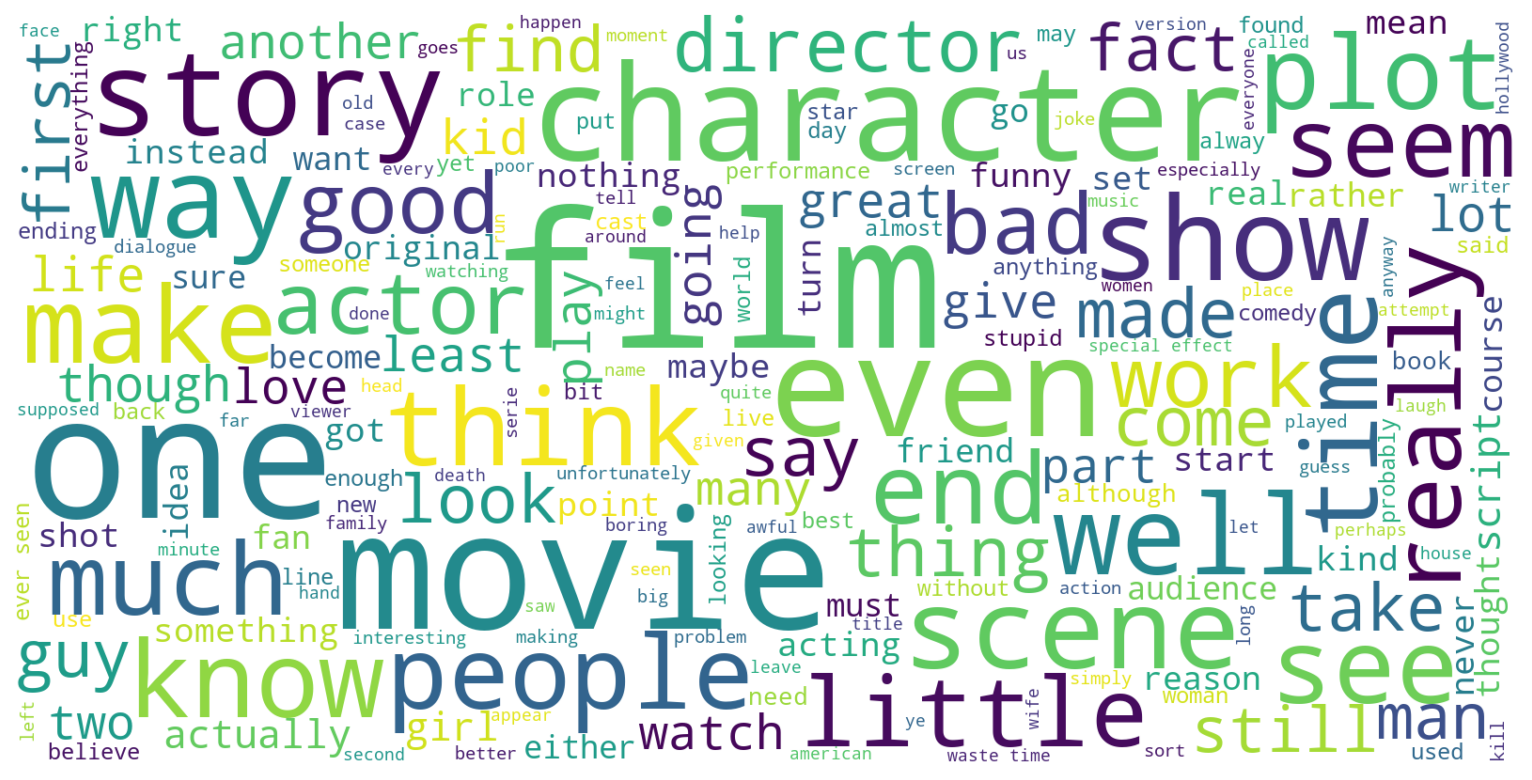

In [15]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS


neg_tweets = train[train.Neg == 1]
neg_string = []
for t in neg_tweets.Text_Final:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

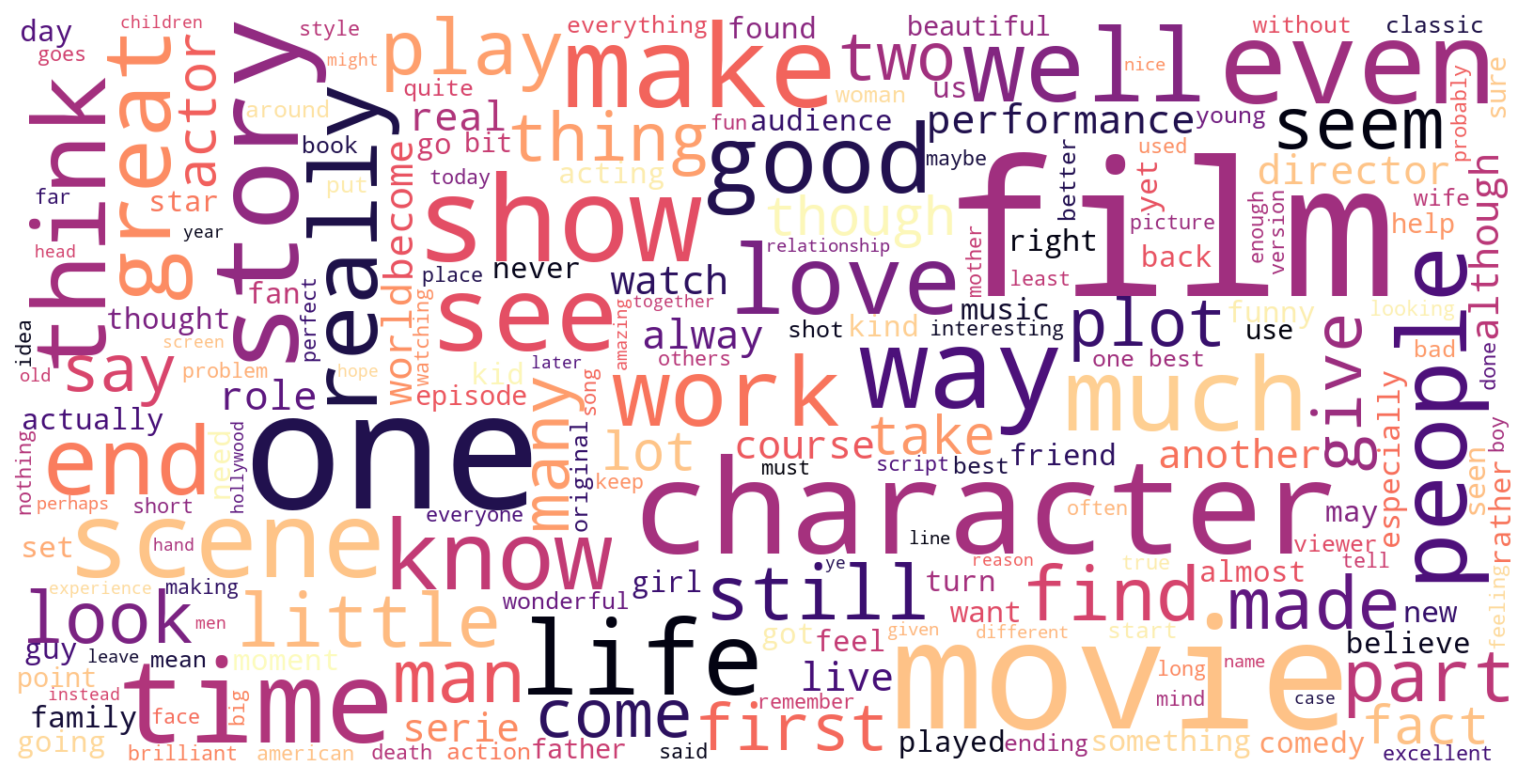

In [16]:
pos_tweets = train[train.Pos == 1]
pos_string = []
for t in pos_tweets.Text_Final:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma', background_color='white').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(train, test_size=0.10, random_state=42)

In [18]:
all_training_words = [word for tokens in data_train["Tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["Tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

5311811 words total, with a vocabulary size of 97591
Max sentence length is 1417


In [19]:
all_test_words = [word for tokens in data_test["Tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["Tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

596385 words total, with a vocabulary size of 38689
Max sentence length is 587


In [20]:
import gensim.models.keyedvectors as word2vec
word2vec_path = "/kaggle/input/google-news-vectors/GoogleNews-vectors-negative300-SLIM.bin"
word2vec = word2vec.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [21]:
def get_average_word2vec(tokens_list, vector, generate_missing=True, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['Tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [22]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [23]:
MAX_SEQUENCE_LENGTH = 544
EMBEDDING_DIM = 300

In [24]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Using TensorFlow backend.


Found 97591 unique tokens.


In [25]:
from keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [26]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(97592, 300)


In [27]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
x_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [28]:
label_names = ['Pos', 'Neg']

In [29]:
y_train = data_train[label_names].values
y_test = data_test[label_names].values

In [30]:
from keras.layers import Dense, Dropout, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.models import Model
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [31]:
import tensorflow as tf
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [32]:
with tpu_strategy.scope():
    model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 544)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 544, 300)     29277600    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 543, 200)     120200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 542, 200)     180200      embedding_1[0][0]                
____________________________________________________________________________________________

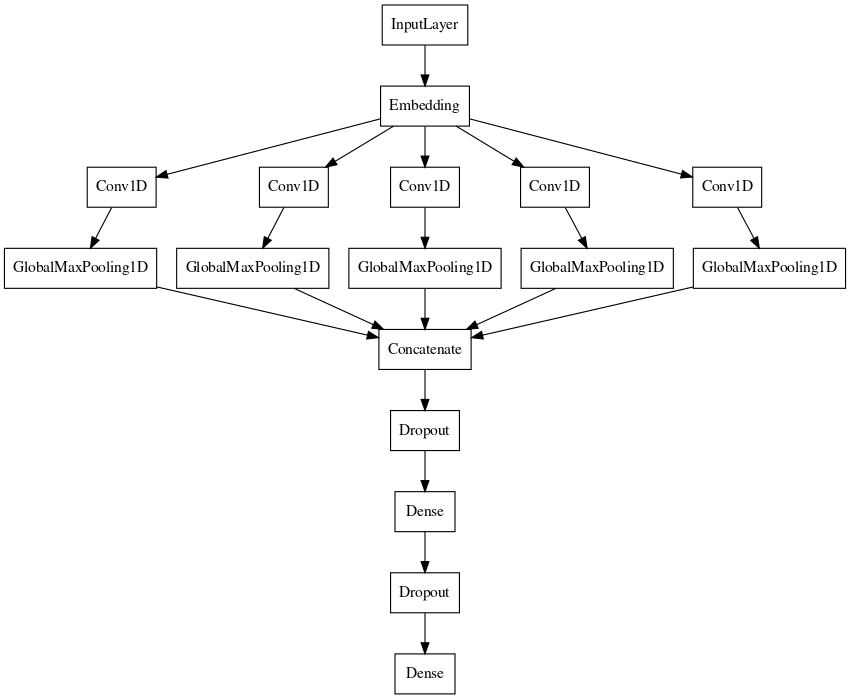

In [33]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=False,
    rankdir='TB', expand_nested=False, dpi=80
)

In [34]:
num_epochs = 50
batch_size = 32 * tpu_strategy.num_replicas_in_sync

In [35]:
# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [36]:
cnn_model = model.fit(x_train, y_train, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size, callbacks=[es])

Train on 40500 samples, validate on 4500 samples
Epoch 1/50
40500/40500 [==============================] - 114s 3ms/step - loss: 0.6199 - acc: 0.6379 - val_loss: 0.3716 - val_acc: 0.8426
Epoch 2/50
40500/40500 [==============================] - 114s 3ms/step - loss: 0.3483 - acc: 0.8517 - val_loss: 0.2882 - val_acc: 0.8764
Epoch 3/50
40500/40500 [==============================] - 113s 3ms/step - loss: 0.2773 - acc: 0.8880 - val_loss: 0.2685 - val_acc: 0.8836
Epoch 4/50
40500/40500 [==============================] - 113s 3ms/step - loss: 0.2266 - acc: 0.9129 - val_loss: 0.2473 - val_acc: 0.8917
Epoch 5/50
40500/40500 [==============================] - 114s 3ms/step - loss: 0.1693 - acc: 0.9400 - val_loss: 0.2793 - val_acc: 0.8837
Epoch 00005: early stopping


In [37]:
# score = model.evaluate(x_test, y_test, verbose=1)
# print("Test Score:", score[0])
# print("Test Accuracy:", score[1])
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.952, Test: 0.887


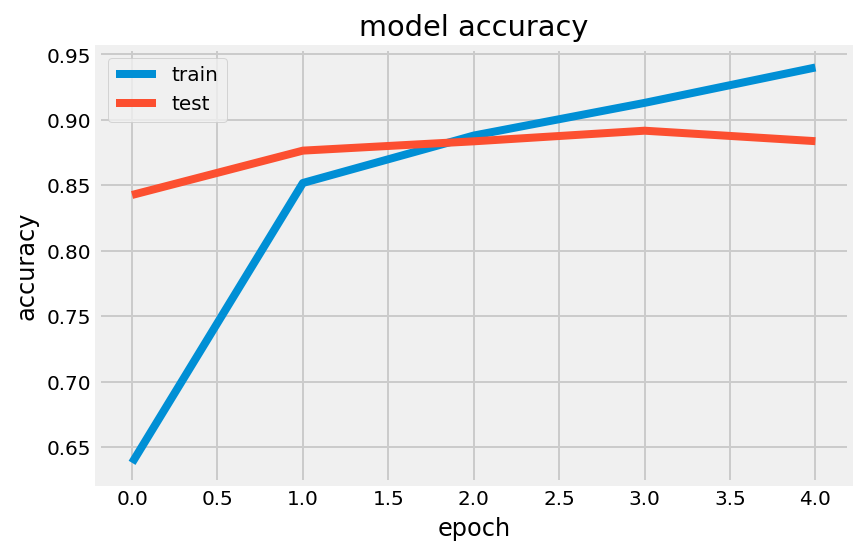

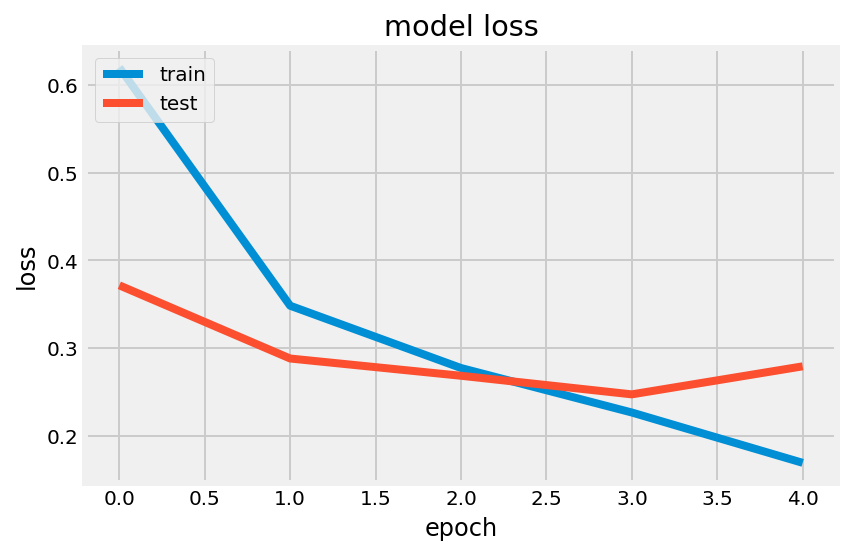

In [38]:
plt.plot(cnn_model.history['acc'])
plt.plot(cnn_model.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

In [40]:
#F1 Score, Recall and Precision
target_names=['Positive', 'Negative']
y_pred = model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.94      0.83      0.88      2519
    Negative       0.85      0.94      0.89      2481

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



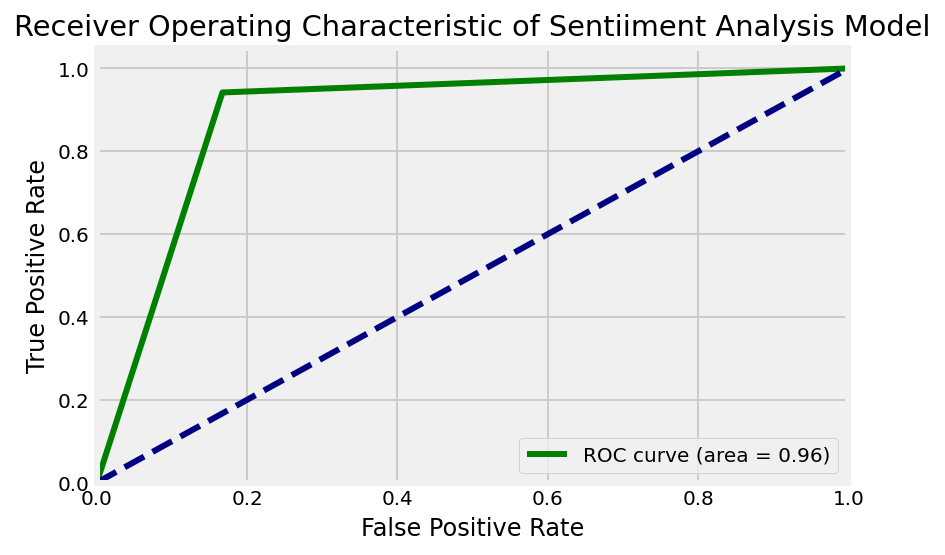

In [41]:
#ROC AUC curve
rocAuc = roc_auc_score(y_test, y_pred)

falsePositiveRate, truePositiveRate, _ = roc_curve(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure()

plt.plot(falsePositiveRate, truePositiveRate, color='green',
         lw=3, label='ROC curve (area = %0.2f)' % rocAuc)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Sentiiment Analysis Model')
plt.legend(loc="lower right")
plt.show()

In [42]:
#Other accuracy metrices
y_pred = (y_pred > 0.5)

#confusion metrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

[[2100  419]
 [ 148 2333]]


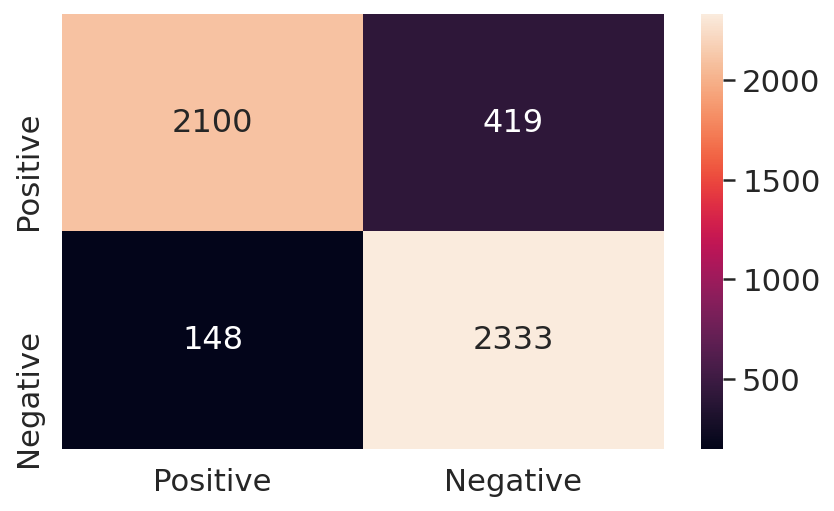

In [43]:
import seaborn as sn
sn.set(font_scale=1.4) # for label size
x_axis_labels = y_axis_labels = target_names
sn.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

In [44]:
# movie reviews from IMDB website, Jocker Movie (2019)
t_1 = "This is a movie that only those who have felt alone and isolated can truly relate to it. You understand the motive and you feel sorry for the character. A lot of people will see this movie and think that it encourages violence. But truly, this movie should encourage each and every one of us to become a better person, treat everyone with respect and make each other feel like they belong in this world, instead of making them feel isolated."
t_2 = "Truly a masterpiece, The Best Hollywood film of 2019, one of the Best films of the decade... And truly the Best film to bring a comic book so chillingly and realistically to real ife. Remarkable Direction, Cinematography, Music and the Acting. Some people are surprised to find it DISTURBING and VIOLENT, but it's a necessity and message. It's about society and reflects those underappreciated/unrecognized/bullied people, proving they can do something too. The way it shows class difference, corruption and how rich and talented rule others around them is not exaggerated and that's what makes it different. It's BELIEVABLE. There could be multiple JOKERs living in our society that could shake those around them in much bitter way than the film shows making people uncomforting people. Consider this a wake up call, a message, but first a film. A PERFECT film."
t_3 = "Joaquin Phoenix gives a tour de force performance, fearless and stunning in its emotional depth and physicality. It's impossible to talk about this without referencing Heath Ledger's Oscar-winning performance from The Dark Knight, widely considered the definitive live-action portrayal of the Joker, so let's talk about it. The fact is, everyone is going to be stunned by what Phoenix accomplishes, because it's what many thought impossible - a portrayal that matches and potentially exceeds that of The Dark Knight's Clown Prince of Crime"
tests = [t_1, t_2, t_3]
tests_tokens = tokenizer.texts_to_sequences(tests)
test_tokens_pad = pad_sequences(tests_tokens, maxlen=MAX_SEQUENCE_LENGTH)

# predict
model.predict(x=test_tokens_pad)

array([[0.3787877 , 0.6135259 ],
       [0.9984572 , 0.00149614],
       [0.9760224 , 0.0227139 ]], dtype=float32)

In [46]:
model.save('sentiment_analysis_using_cnn.h5')